# Importing configurations and modules

In [1]:
import numpy as np
import pandas as pd
import tf_keras as keras
import tensorflow as tf
import tensorflow_hub as hub

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB 
from sklearn.feature_extraction.text import TfidfVectorizer

from tf_keras.layers import TextVectorization,Embedding,Dense,Conv1D,GlobalAveragePooling1D
from tf_keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
import tensorflow as tf
from tf_keras.optimizers import Adam

2024-11-21 18:31:35.483517: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-21 18:31:36.709098: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732194097.178820  503721 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732194097.263449  503721 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-21 18:31:38.274943: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [ ]:
from config.config import *
from callbacks.callbacks import *
from evaluation import get_cm_and_final_results

2024-11-21 16:50:06.758267: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-21 16:50:07.043012: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732188007.144973  488469 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732188007.185505  488469 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-21 16:50:07.621642: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [4]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 4050 Laptop GPU (UUID: GPU-3c98d5c3-b19e-acfa-02d3-5c9d5dfaedd2)


# Data processing and understanding

In [5]:
DATA_DIR = DATASET_DIR.joinpath('pubmed-rct')

In [6]:
os.listdir(DATA_DIR)

['PubMed_200k_RCT',
 'PubMed_20k_RCT',
 'PubMed_200k_RCT_numbers_replaced_with_at_sign',
 'PubMed_20k_RCT_numbers_replaced_with_at_sign']

In [7]:
DATASET = 'PubMed_20k_RCT_numbers_replaced_with_at_sign'
DATA_FILES = [DATA_DIR.joinpath(DATASET).joinpath(x) for x in os.listdir(DATA_DIR.joinpath(DATASET))]

In [8]:
DATA_FILES

[PosixPath('/home/yehand/.vscode-server/projects/NLP_Learning/JSCReplication/datasets/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt'),
 PosixPath('/home/yehand/.vscode-server/projects/NLP_Learning/JSCReplication/datasets/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt'),
 PosixPath('/home/yehand/.vscode-server/projects/NLP_Learning/JSCReplication/datasets/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt')]

In [9]:
data = dict()
for path in DATA_FILES:
    with open(path) as file:
        data[file.name.split('/')[-1].split('.')[0]] = file.readlines()

In [10]:
data.keys()

dict_keys(['test', 'train', 'dev'])

In [11]:
start = 0
amount = 20
for key in data:
    print('--------------------------------------------------------------------------------------------------\nData from Dataset', key)
    print(np.array(data[key][start: start+amount]))

--------------------------------------------------------------------------------------------------
Data from Dataset test
['###24845963\n'
 'BACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n'
 'RESULTS\tA post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .\n'
 'RESULTS\tLiver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .\n'
 'RESULTS\tSurvival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .\n'
 "RESULTS\tT

## To be more computer friendlty let's preprocess using a function

In [12]:
def process_data(file_name : str) -> list:
    """
    Process a structured text file containing abstracts and convert it into a list of dictionaries.

    Parameters:
        file_name: str
            Path to the input file.
            Expected file format:
            - Abstract headers marked with '###' followed by ID
            - Each line contains tab-separated target and text
            - Abstracts separated by blank lines

    Returns:
        List[Dict[str, Union[str, int]]]: A list of dictionaries, where each dictionary contains:
            - target (str): The target label from the input
            - text (str): The lowercase text content
            - line_number (int): Line position within the abstract (0-based)
            - total_lines (int): Total number of lines in the abstract
            - abstract_id (int): ID extracted from the abstract header

    Raises:
        FileNotFoundError: If the specified file does not exist
        IOError: If there are issues reading the file
        ValueError: If:
            - Abstract ID cannot be converted to integer
            - Line doesn't contain enough tab-separated fields
            - Malformed header line (missing '###' or ID)
        IndexError: If trying to access parts of malformed lines
        TypeError: If file_name is not a string

    Example:
        >>> data = process_data('abstracts.txt')
        >>> print(data[0])
        {
            'target': 'BACKGROUND',
            'text': 'example text here',
            'line_number': 0,
            'total_lines': 5,
            'abstract_id': 1234
        }

    Notes:
        - Text is automatically converted to lowercase for processing efficiency
        - Abstract headers must start with '###' followed by ID
        - Each abstract must end with a blank line
        - Lines must contain at least two tab-separated fields
    """
    data = list()
    with open(file_name) as file:
        data_lines = file.readlines()
    for line in data_lines:
        if line[:3] == '###':
            line_number = 0
            id = line[4:-2]
            abstract = []
            continue
        elif line == '\n':
            for item in abstract:
                item['total_lines'] = line_number
                data.append(item)
        else:
            target, text = line.split('\t')[:2]
            abstract.append(
                {
                    'target' : target,
                    'text' : text.lower(), #lowercase for efficiency
                    'line_number' : line_number,
                    'total_lines' : 0,
                    'abstract_id' : int(id)
                    }
            )
        line_number+=1
    return data

In [13]:
%%time

test = process_data(DATA_FILES[0])
train = process_data(DATA_FILES[1])
val = process_data(DATA_FILES[2])

len(test) ,len(train), len(val)

CPU times: user 307 ms, sys: 134 ms, total: 441 ms
Wall time: 456 ms


(30135, 180040, 30212)

In [14]:
test = process_data(DATA_FILES[0])
train = process_data(DATA_FILES[1])
val = process_data(DATA_FILES[2])
train_df = pd.DataFrame(train)
test_df = pd.DataFrame(test)
val_df = pd.DataFrame(val)

## Visualizing the processed data

In [15]:
train_df.head(20)

,target,text,line_number,total_lines,abstract_id
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,12,429357
1,METHODS,a total of @ patients with primary knee oa wer...,1,12,429357
2,METHODS,outcome measures included pain reduction and i...,2,12,429357
3,METHODS,pain was assessed using the visual analog pain...,3,12,429357
4,METHODS,secondary outcome measures included the wester...,4,12,429357
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,12,429357
6,RESULTS,there was a clinically relevant reduction in t...,6,12,429357
7,RESULTS,the mean difference between treatment arms ( @...,7,12,429357
8,RESULTS,"further , there was a clinically relevant redu...",8,12,429357
9,RESULTS,these differences remained significant at @ we...,9,12,429357


In [16]:
NUM_CLASSES = train_df['target'].nunique()
train_df['target'].value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

In [17]:
def word_count(text : str):
    return len([x for x in text.split()])

word_counts = train_df['text'].apply(word_count)

<Axes: ylabel='Frequency'>

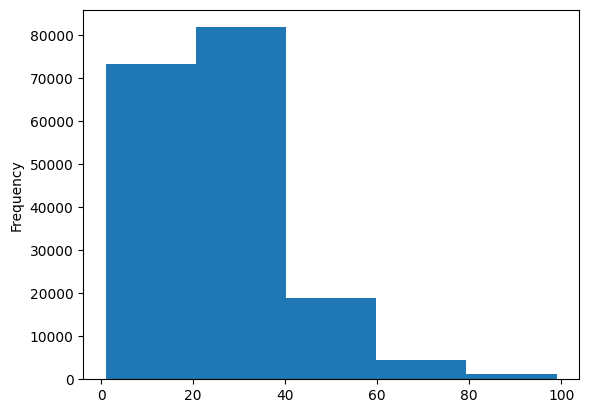

In [18]:
word_counts[word_counts < 100].plot.hist(bins = 5)

<Axes: ylabel='Frequency'>

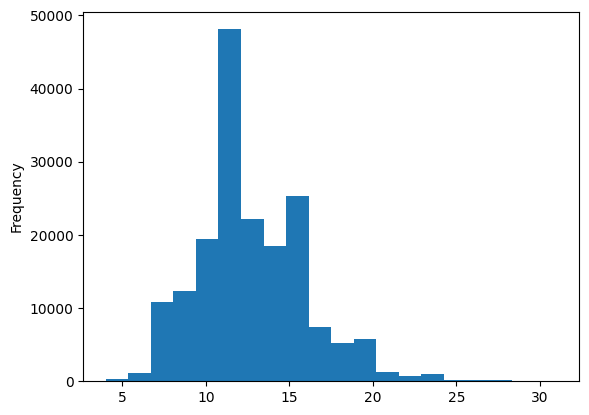

In [19]:
train_df.total_lines.plot.hist(bins = 20)

In [20]:
X_train = train_df['text'].to_numpy()
X_test = test_df['text'].to_numpy()
X_val = val_df['text'].to_numpy()

## Converting labels to numerical format

### One Hot

In [ ]:
# Same results using sklearn
one_hot = OneHotEncoder(sparse_output=False)
train_one_hot = one_hot.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
test_one_hot = one_hot.transform(test_df['target'].to_numpy().reshape(-1,1))
val_one_hot = one_hot.transform(val_df['target'].to_numpy().reshape(-1,1))

In [22]:
train_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label Encoding

In [ ]:
label_encoder = LabelEncoder()
train_label = label_encoder.fit_transform(train_df['target'].to_numpy())
test_label = label_encoder.transform(test_df['target'].to_numpy())
val_label = label_encoder.transform(val_df['target'].to_numpy())

In [24]:
train_label

array([3, 2, 2, ..., 4, 1, 1])

In [25]:
CLASS_NAMES  = label_encoder.classes_

In [26]:
CLASS_NAMES

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

# Creating Model Baseline

In [ ]:
model_0 = Pipeline(
    steps=[
        ('vectorizer', TfidfVectorizer()),
        ( 'clf', MultinomialNB())
    ]
)

In [28]:
model_0.fit(X_train, train_label)

Pipeline(steps=[('vectorizer', TfidfVectorizer()), ('clf', MultinomialNB())])

In [29]:
baseline_preds = model_0.predict(X_val)

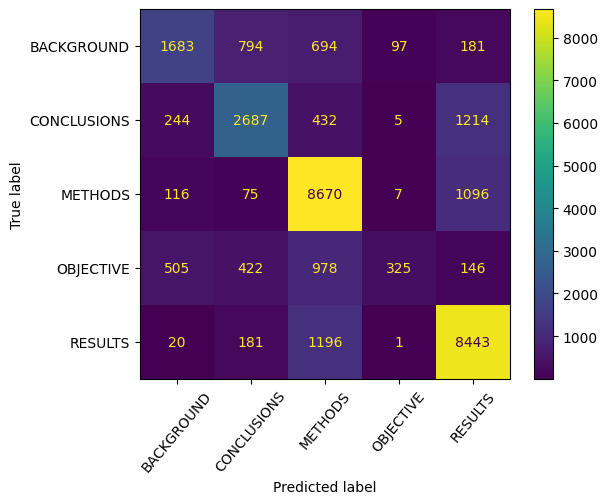

In [ ]:
baseline_cm, baseline_report, baseline_metrics = get_cm_and_final_results(baseline_preds, val_label)

In [31]:
baseline_metrics

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

# Model Version 1 - Simple CNN based

In [33]:
np.percentile(word_counts, 95)

55.0

In [34]:
VOCAB_SIZE = 68000
NUM_TOKENS = 55
vectorizer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_sequence_length=NUM_TOKENS,
)

I0000 00:00:1732188025.048274  488469 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [35]:
vectorizer.adapt(X_train)

In [36]:
len(vectorizer.get_vocabulary())

64841

In [37]:
sent = np.random.choice(X_train)

print(sent)

print(vectorizer(sent))

shifting to an approach based on cvar will require more intensive intervention .

tf.Tensor(
[10977     6    26   453   261    18 20859    95  1942    69   642    38
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0], shape=(55,), dtype=int64)


In [38]:
EMBEDDING_DIMENSIONS = 128
model_1_embedding = Embedding(
    input_dim=len(vectorizer.get_vocabulary()),
    output_dim=EMBEDDING_DIMENSIONS,
    mask_zero=True,
)

In [39]:
EMBEDDING_DIMENSIONS = 128
model_1_embedding = Embedding(
    input_dim=len(vectorizer.get_vocabulary()),
    output_dim=EMBEDDING_DIMENSIONS,
    mask_zero=True,
)

inputs = keras.layers.Input(shape=(1,), dtype=tf.string)

x = vectorizer(inputs)
x = model_1_embedding(x)
x = keras.layers.Conv1D(128,7, activation='relu')(x)
x = keras.layers.MaxPool1D(2)(x)
x = keras.layers.Conv1D(64,3,activation='relu')(x)
x = keras.layers.MaxPool1D(2)(x)
x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dense(64, activation='relu')(x)
outputs = keras.layers.Dense(NUM_CLASSES,activation = 'softmax')(x)

model_1 = keras.Model(inputs,outputs)

model_1.compile(
    optimizer= keras.optimizers.Adam(), 
    loss = CategoricalCrossentropy(), 
    metrics=['accuracy']#, keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.F1Score()]
    )

/home/yehand/anaconda3/envs/tfbootcamp/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [40]:
model_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 55)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 55, 128)        │     8,299,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 49, 128)        │       114,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 22, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,443,589 (32.21 MB)

 Trainable params: 8,443,589 (32.21 MB)

 Non-trainable params: 0 (0.00 B)

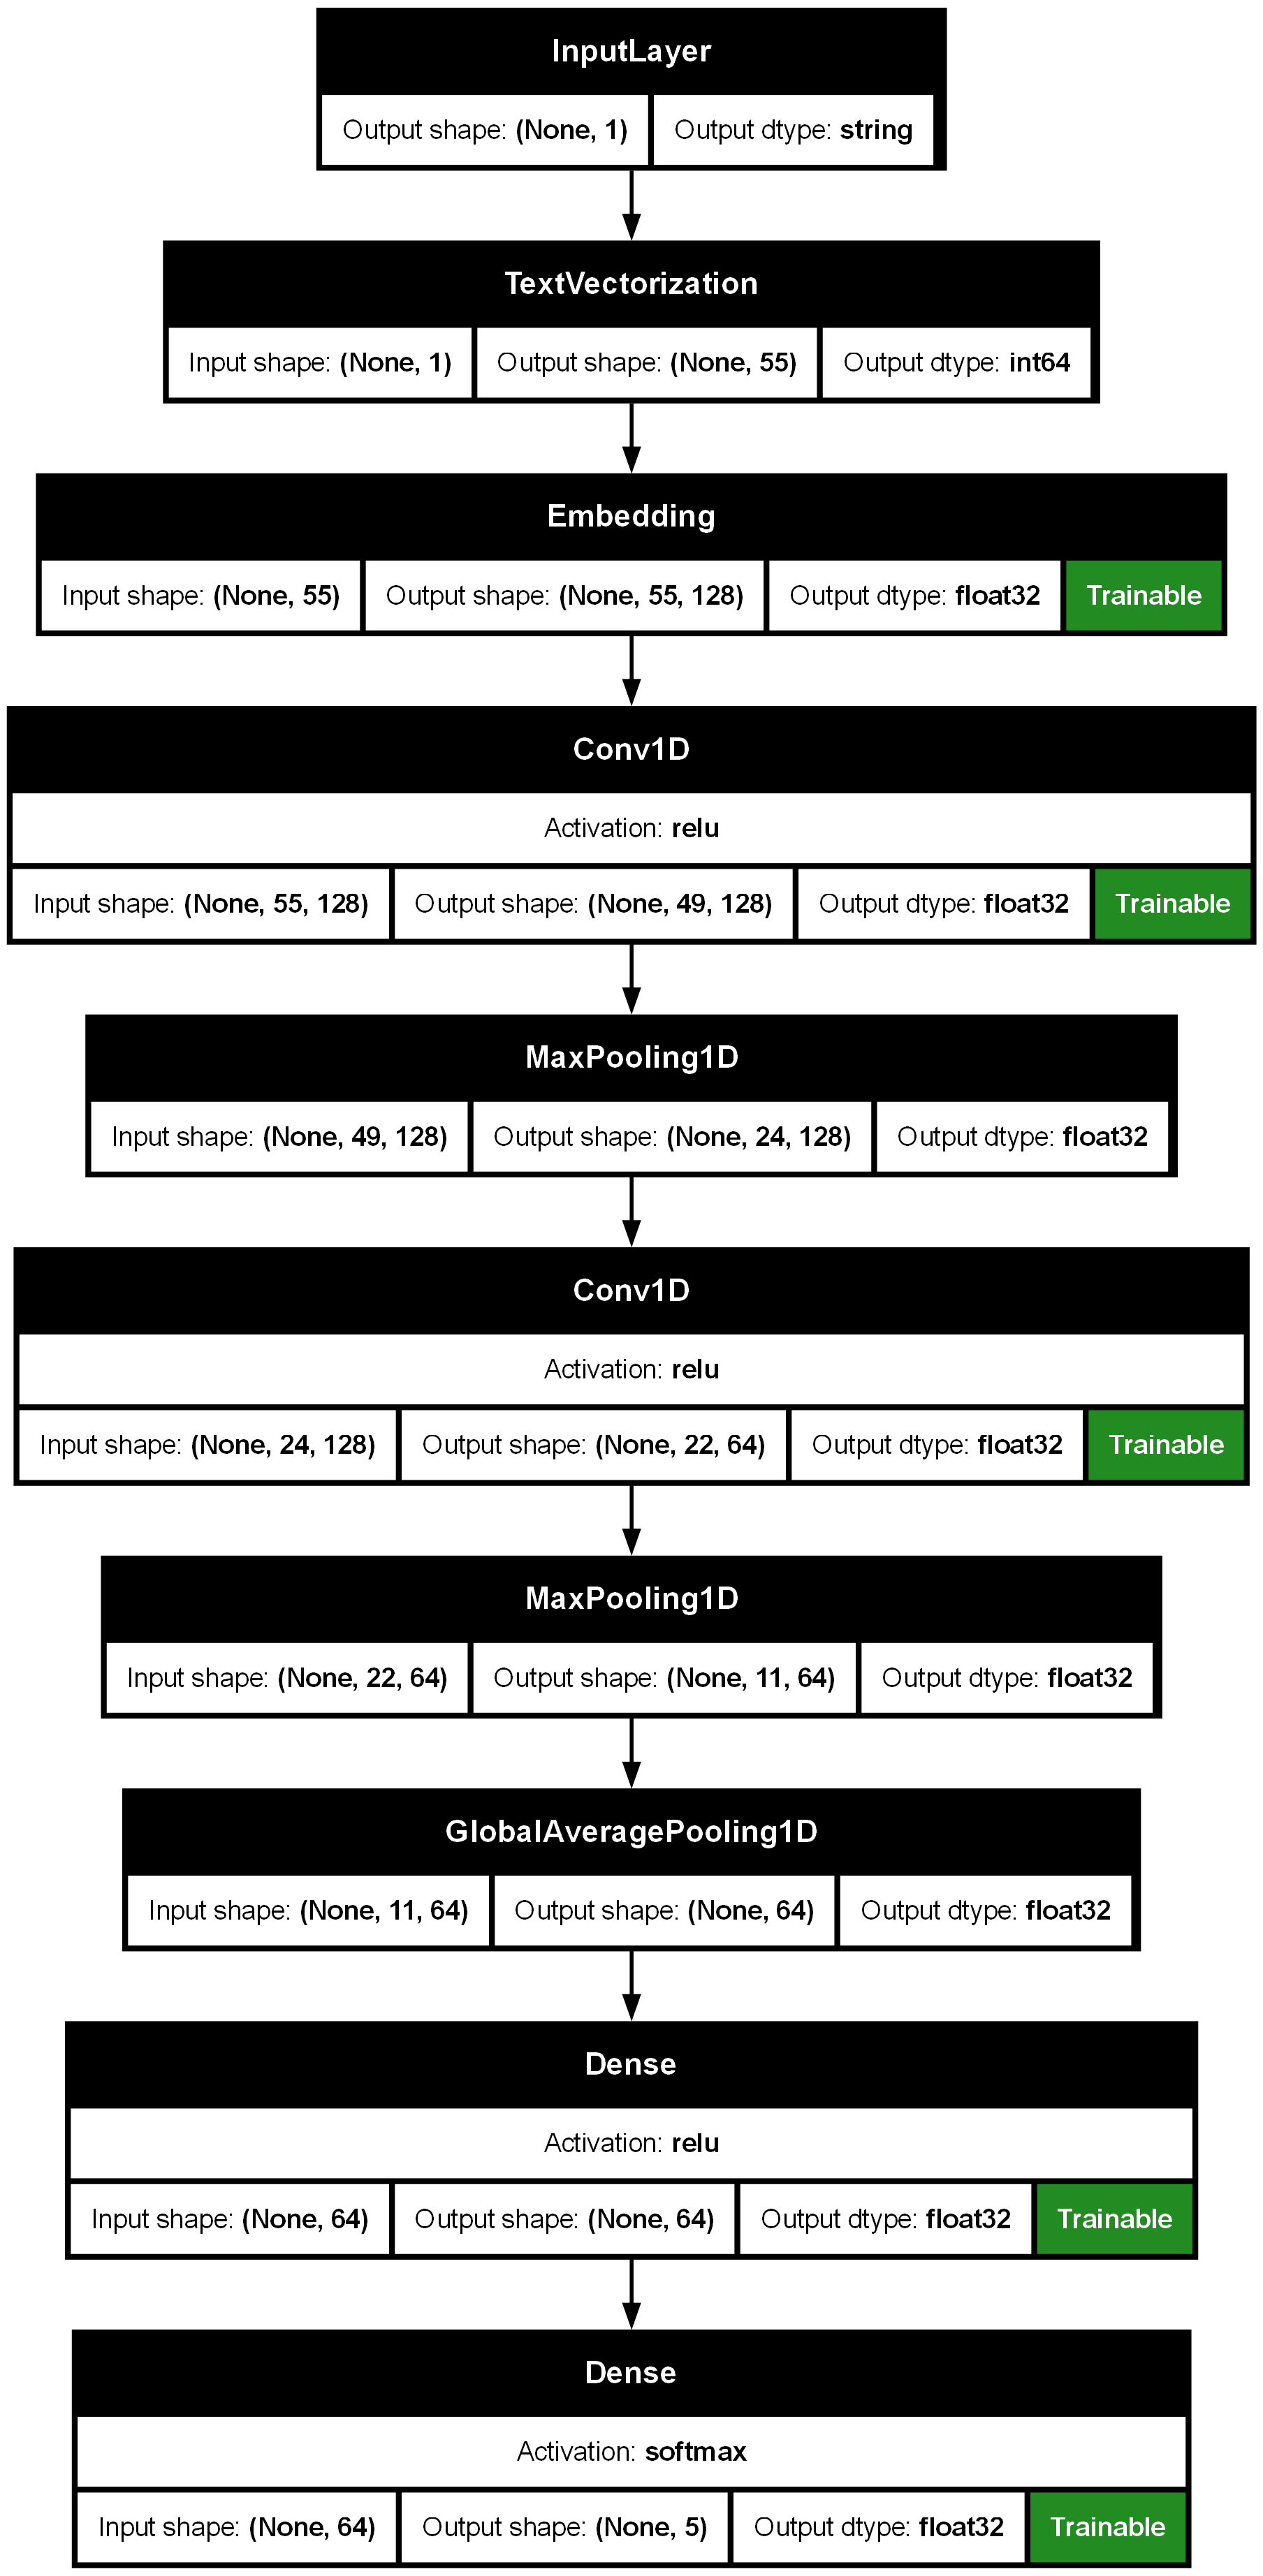

In [41]:
keras.utils.plot_model(
    model=model_1, 
    show_dtype=True,
    show_layer_activations=True,
    expand_nested=True,
    show_shapes=True,
    show_trainable=True
                       )

In [42]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [43]:
len(X_train)/320

562.625

In [44]:
history_model_1 = model_1.fit(
    X_train,
    train_one_hot,
    validation_data = (X_val, val_one_hot),
    epochs=3,
    initial_epoch=0,
    callbacks=[create_tensorboard_callback('CNN', 'RUN1')],
    steps_per_epoch = 560,
    validation_steps = 560,
    batch_size=BATCH_SIZE
)

Saving log files to : /home/yehand/.vscode-server/projects/NLP_Learning/JSCReplication/experiments/CNN/RUN1
Epoch 1/3


I0000 00:00:1732188037.071345  488627 cuda_dnn.cc:529] Loaded cuDNN version 90300


560/560 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.5220 - loss: 1.1242 - val_accuracy: 0.7353 - val_loss: 0.6947
Epoch 2/3
560/560 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.7290 - loss: 0.6883 - val_accuracy: 0.7650 - val_loss: 0.6240
Epoch 3/3


2024-11-21 16:51:11.381882: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-21 16:51:11.382028: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-11-21 16:51:11.382088: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18192647918282408691
2024-11-21 16:51:11.382099: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1090484351434540535
2024-11-21 16:51:11.382109: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13547982946581051633
2024-11-21 16:51:11.382116: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6928762428157786899
2024-11-2

560/560 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.7666 - loss: 0.6234 - val_accuracy: 0.7882 - val_loss: 0.5689


In [45]:
model_1_preds = np.argmax(model_1.predict(X_val),axis=-1)
model_1_preds, val_label

945/945 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


(array([3, 0, 3, ..., 4, 1, 1]), array([0, 0, 3, ..., 4, 1, 1]))

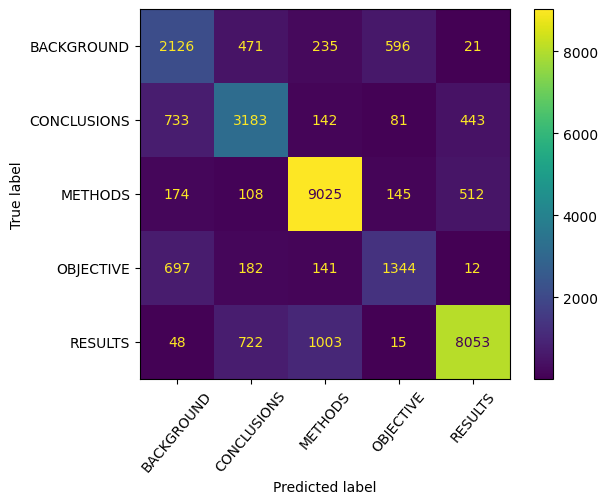

In [46]:
model_1_cm, model_1_report, model_1_metrics = get_cm_and_final_results(model_1_preds, val_label)

In [47]:
model_1_report

,BACKGROUND,CONCLUSIONS,METHODS,OBJECTIVE,RESULTS,accuracy,macro avg,weighted avg
precision,0.562732,0.682169,0.855775,0.616231,0.890720,0.785483,0.721525,0.788536
recall,0.616411,0.694675,0.905761,0.565657,0.818311,0.785483,0.720163,0.785483
f1-score,0.588349,0.688365,0.880059,0.589862,0.852982,0.785483,0.719923,0.786042
support,3449.000000,4582.000000,9964.000000,2376.000000,9841.000000,0.785483,30212.000000,30212.000000


In [48]:
model_1_report -  baseline_report

,BACKGROUND,CONCLUSIONS,METHODS,OBJECTIVE,RESULTS,accuracy,macro avg,weighted avg
precision,-0.092642,0.036100,0.131464,-0.130895,0.128716,0.06365,0.014549,0.069889
recall,0.128443,0.108250,0.035628,0.428872,-0.039630,0.06365,0.132313,0.063650
f1-score,0.028934,0.073561,0.089505,0.358627,0.045850,0.06365,0.119296,0.087117
support,0.000000,0.000000,0.000000,0.000000,0.000000,0.06365,0.000000,0.000000


## Processing data to tf Datasets to make faster calculations

In [49]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    tensors=(X_train, train_one_hot)
    ).batch(
            batch_size=BATCH_SIZE,num_parallel_calls=tf.data.AUTOTUNE
            ).cache().prefetch(
                buffer_size=tf.data.AUTOTUNE
                )
test_dataset = tf.data.Dataset.from_tensor_slices(
    tensors=(X_test, test_one_hot)
    ).batch(
            batch_size=BATCH_SIZE,num_parallel_calls=tf.data.AUTOTUNE
            ).cache().prefetch(
                buffer_size=tf.data.AUTOTUNE
                )
val_dataset = tf.data.Dataset.from_tensor_slices(
    tensors=(X_val, val_one_hot)
    ).batch(
            batch_size=BATCH_SIZE,num_parallel_calls=tf.data.AUTOTUNE
            ).cache().prefetch(
                buffer_size=tf.data.AUTOTUNE
                )


In [50]:
for line,label in train_dataset.take(1):
    print(np.concatenate((np.expand_dims(line.numpy(), axis=-1), label.numpy()),axis=-1)[:5])

[[b'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .\n'
  0.0 0.0 0.0 1.0 0.0]
 [b'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n'
  0.0 0.0 1.0 0.0 0.0]
 [b'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n'
  0.0 0.0 1.0 0.0 0.0]
 [b'pain was assessed using the visual analog pain scale ( @-@ mm ) .\n'
  0.0 0.0 1.0 0.0 0.0]
 [b'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .\n'
  0.0 0.0 1.0 0.0 0.0]]


2024-11-21 16:51:29.187503: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


# Updating model to fit in with new procedure

In [51]:
#Enabling mixed float
keras.mixed_precision.set_global_policy('mixed_float16')

In [52]:
EMBEDDING_DIMENSIONS = 128
model_1_embedding = Embedding(
    input_dim=len(vectorizer.get_vocabulary()),
    output_dim=EMBEDDING_DIMENSIONS,
    mask_zero=True,
)

inputs = keras.layers.Input(shape=(1,), dtype=tf.string)

x = vectorizer(inputs)
x = model_1_embedding(x)
x = keras.layers.Conv1D(128,7, activation='relu')(x)
x = keras.layers.MaxPool1D(2)(x)
x = keras.layers.Conv1D(64,3,activation='relu')(x)
x = keras.layers.MaxPool1D(2)(x)
x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dense(NUM_CLASSES)(x)
outputs = keras.layers.Activation(keras.activations.softmax, dtype=tf.float32)(x)

model_1 = keras.Model(inputs,outputs)

model_1.compile(
    optimizer= keras.optimizers.Adam(), 
    loss = CategoricalCrossentropy(), 
    metrics=['accuracy']#, keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.F1Score()]
    )

/home/yehand/anaconda3/envs/tfbootcamp/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'conv1d_2' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [53]:
def plot_model(model):
    return keras.utils.plot_model(
    model=model, 
    show_dtype=True,
    show_layer_activations=True,
    expand_nested=True,
    show_shapes=True,
    show_trainable=True
                       )

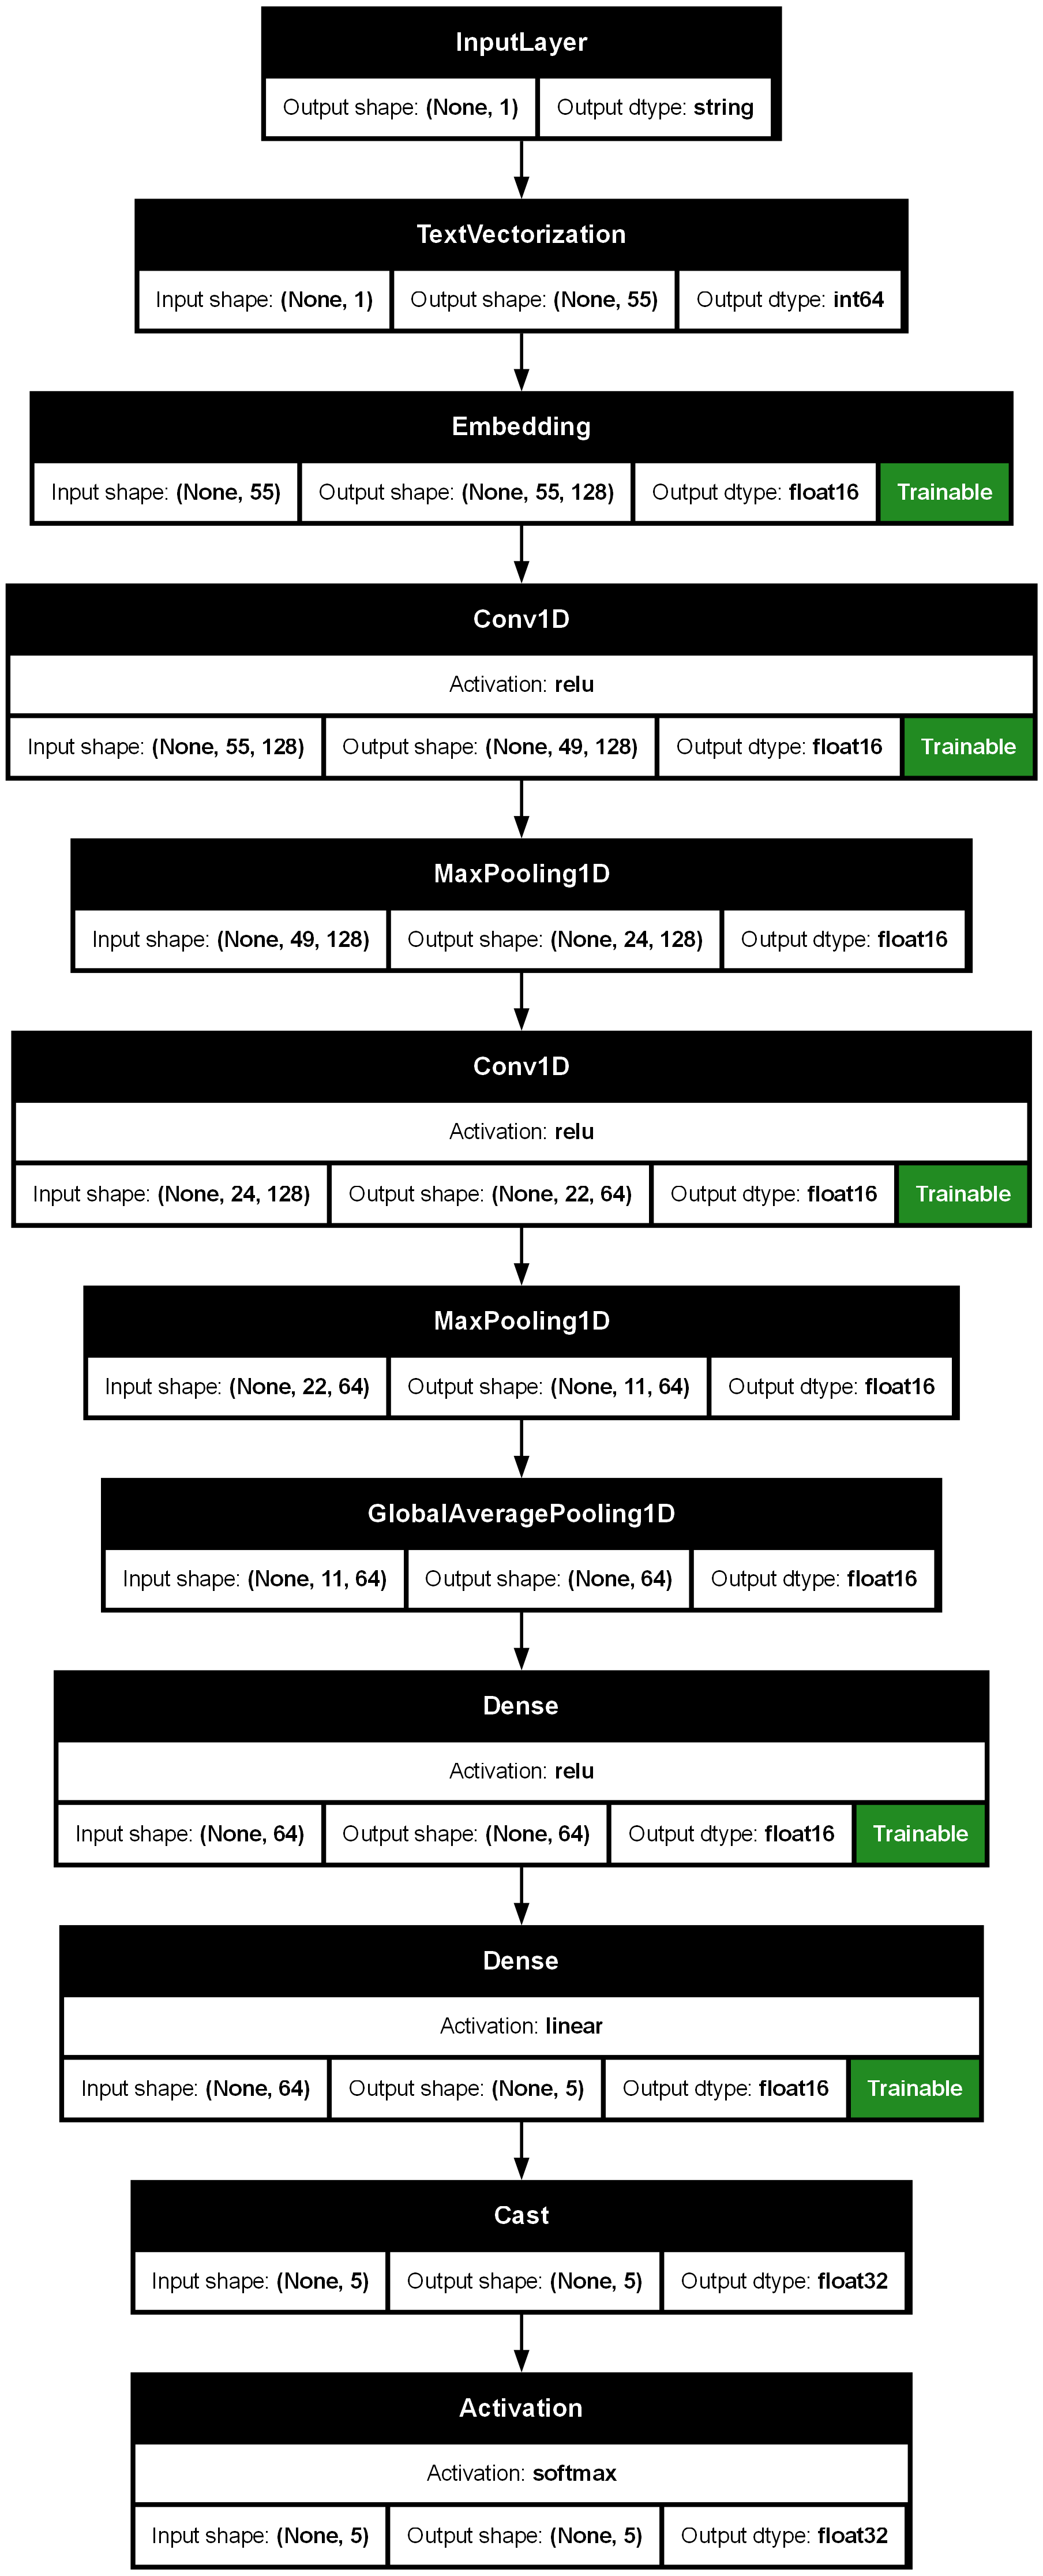

In [54]:
keras.utils.plot_model(
    model=model_1, 
    show_dtype=True,
    show_layer_activations=True,
    expand_nested=True,
    show_shapes=True,
    show_trainable=True
                       )

In [55]:
model_1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 55)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 55, 128)        │     8,299,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 49, 128)        │       114,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 22, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast (Cast)                     │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,443,589 (32.21 MB)

 Trainable params: 8,443,589 (32.21 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
history_model_1 = model_1.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs=3,
    initial_epoch=0,
    batch_size=BATCH_SIZE,
    callbacks=[create_tensorboard_callback('CNN', 'RUN2')],
    steps_per_epoch = int(len(train_dataset)/10),
    validation_steps = int(len(val_dataset)/10)
)

Saving log files to : /home/yehand/.vscode-server/projects/NLP_Learning/JSCReplication/experiments/CNN/RUN2
Epoch 1/3


2024-11-21 16:51:36.519470: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


562/562 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.5271 - loss: 1.1345 - val_accuracy: 0.7301 - val_loss: 0.7057
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.7339 - loss: 0.6918 - val_accuracy: 0.7623 - val_loss: 0.6189
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.7642 - loss: 0.6231 - val_accuracy: 0.7779 - val_loss: 0.5709


2024-11-21 16:52:20.235972: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-11-21 16:52:20.237923: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [57]:
model_1_preds = np.argmax(model_1.predict(val_dataset), axis=-1)

945/945 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


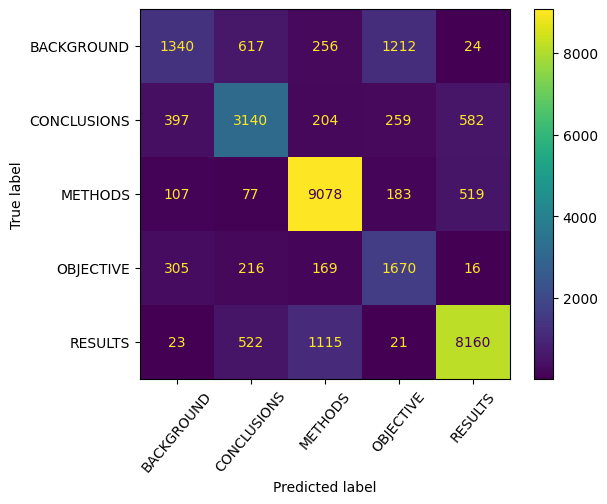

In [58]:
model_1_cm, model_1_report, model_1_metrics = get_cm_and_final_results(model_1_preds, val_label)

# Model Version 2 - Pretrained Embeddings

In [ ]:
universal_sentence_encoder = hub.KerasLayer(
    handle="https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2",
    trainable=False,
    name='USE'
)

In [70]:
universal_sentence_encoder([' what joja', 'n'])

<tf.Tensor: shape=(2, 512), dtype=float32, numpy=
array([[-0.04555983, -0.00660281, -0.01276617, ..., -0.04721962,
         0.07622743,  0.01372085],
       [-0.02442588, -0.03740193, -0.01249437, ..., -0.07511895,
         0.04019829,  0.00873134]], dtype=float32)>

In [ ]:
class USE(keras.layers.Layer):

    def __init__(self, encoder):

        super().__init__()
        self.encoder = encoder
    
    def call(self, inputs):
        return self.encoder(inputs)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "encoder": self.encoder,
        })

        return config

In [ ]:
# model_2 = keras.Sequential([
#     keras.layers.Input(shape=[], dtype=tf.string),
#     USE(universal_sentence_encoder),
#     keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dense(NUM_CLASSES),
#     keras.layers.Activation('softmax', dtype=tf.float32),
# ])

# model_2.compile(
#     optimizer= keras.optimizers.Adam(), 
#     loss = keras.losses.CategoricalCrossentropy(), 
#     metrics=['accuracy']#, keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.F1Score()]
#     )

In [79]:
inputs = keras.layers.Input(shape=[], dtype=tf.string)

x = universal_sentence_encoder(inputs, training=False)
# x = keras.layers.Conv1D(128,7, activation='relu')(x)
# x = keras.layers.MaxPool1D(2)(x)
# x = keras.layers.Conv1D(64,3,activation='relu')(x)
# x = keras.layers.MaxPool1D(2)(x)
# x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dense(NUM_CLASSES)(x)
outputs = keras.layers.Activation(keras.activations.softmax, dtype=tf.float32)(x)

model_2 = keras.Model(inputs,outputs)

model_2.compile(
    optimizer= keras.optimizers.Adam(), 
    loss = CategoricalCrossentropy(), 
    metrics=['accuracy']#, keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.F1Score()]
    )

In [77]:
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
 activation_1 (Activation)   (None, 5)                 0         
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [74]:
history_model_2 = model_2.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs=3,
    initial_epoch=0,
    batch_size=BATCH_SIZE,
    #callbacks=[create_tensorboard_callback('USE', 'RUN1')],
    steps_per_epoch = int(len(train_dataset)/10),
    validation_steps = int(len(val_dataset)/10)
)

Epoch 1/3


2024-11-21 18:07:07.201938: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732192627.950089  488620 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


562/562 [==============================] - 35s 33ms/step - loss: 0.9193 - accuracy: 0.6489 - val_loss: 0.8004 - val_accuracy: 0.6842
Epoch 2/3
562/562 [==============================] - 17s 30ms/step - loss: 0.7739 - accuracy: 0.7003 - val_loss: 0.7570 - val_accuracy: 0.7028
Epoch 3/3
562/562 [==============================] - 18s 32ms/step - loss: 0.7566 - accuracy: 0.7101 - val_loss: 0.7432 - val_accuracy: 0.7104


2024-11-21 18:08:02.245552: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
